In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import torch
import torch.nn as nn
# import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.autograd import Variable
import glob, os
# import scipy.misc
from PIL import Image
import numpy as np
import random

data = pickle.load(open('data0.pickle', 'rb'))

x_train = data['x_train']
y_train = data['y_train']
x_valid = data['x_validation']
y_valid = data['y_validation']
x_test = data['x_test']
y_test = data['y_test']

In [16]:
len(x_valid)

4410

In [3]:
train_data = []
for i in range(len(x_train)):    
    train_data.append({
        'label': y_train[i],
        'img': x_train[i]
    })
len(train_data)

test_data = []
for i in range(len(x_test)):    
    test_data.append({
        'label': y_test[i].astype('int64'),
        'img': x_test[i].astype('uint8')
    })
len(test_data)

valid_data = []
for i in range(len(x_valid)):    
    valid_data.append({
        'label': y_valid[i].astype('int64'),
        'img': x_valid[i].astype('uint8')
    })
len(valid_data)

4410

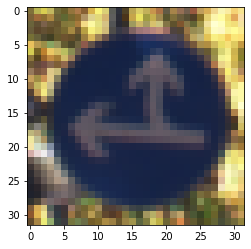

In [4]:
plt.imshow(np.swapaxes(valid_data[1]['img'], 0, 2))

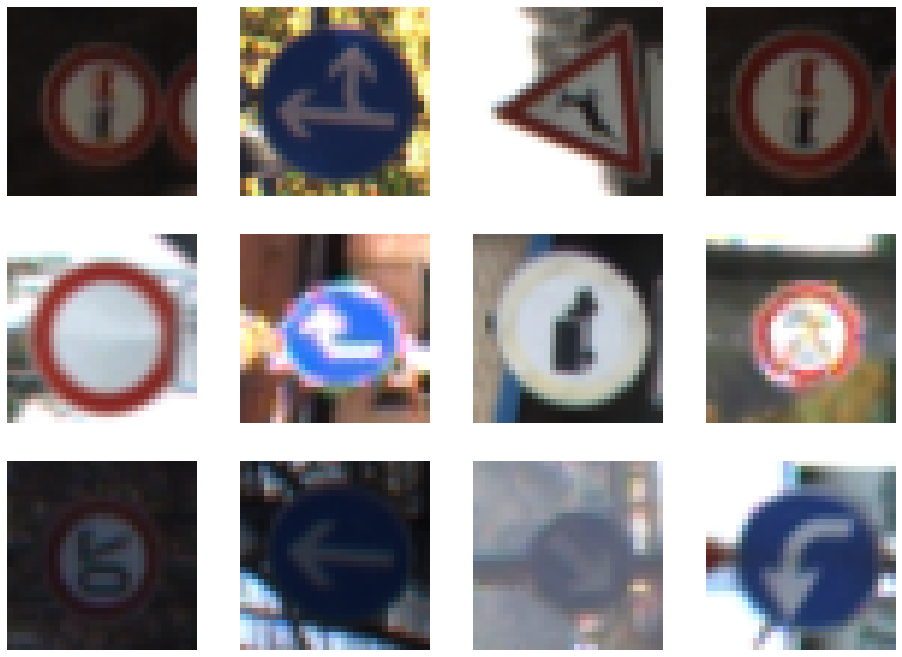

In [5]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 16
next_pic = [np.swapaxes(valid_data[i]['img'],0,2) for i in range(12)]

for i, img in enumerate(next_pic):
  # Set up subplot; subplot indices start at 1
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off') # Don't show axes (or gridlines)

    plt.imshow(img)

plt.show()

In [6]:
class Nnet(nn.Module):

    def __init__(self):
        super(Nnet, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 21 , 3, stride=1, padding=0, bias=False), 
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=1, padding=0),
            nn.Conv2d(21, 20, 3,stride=1, padding=0, bias=False),
            nn.BatchNorm2d(20),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=1, padding=0),
            nn.Conv2d(20, 15, 3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(15),
            nn.ReLU( inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=1, padding=0),
            nn.Conv2d(15,7, 3, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(7),
            nn.ReLU(inplace=True),
        )
        self.fc = nn.Sequential(
            nn.Linear(2800, 50),
            nn.ReLU(inplace=True),
            nn.Linear(50, 44),
            #nn.Softmax()
        )
    def num_flat_features(self, inputs):
        
        # Get the dimensions of the layers excluding the inputs
        size = inputs.size()[1:]
        # Track the number of features
        num_features = 1
        
        for s in size:
            num_features *= s
        
        return num_features

    def forward(self, input):
        #print(input.shape)
        input = input.view(input.shape[0],3,32,32)
        x=self.main(input.float())
        x=x.view(x.shape[0], self.num_flat_features(x))
        return self.fc(x)

In [7]:
'''
  Step 2: Make Data iterable
'''

# separate train data and test data

# random.shuffle(data) # with no seed
random.Random(10).shuffle(train_data) # with seed to ensure consistency

# num_test = 2000
# num_valid = 3000
# # get some sample as test, aka target
# test_data = data[0:num_test]
# valid_data = data[num_test:num_test+num_valid]
# train_data  = data[num_test+num_valid:-1]

train_data = train_data[0:int(len(train_data)/1000)*1000]
valid_data = valid_data[0:int(len(valid_data)/1000)*1000]
test_data = test_data[0:int(len(test_data)/1000)*1000]


# batch size is how many sample to go through each "step"
batch_size = 1000
# how many batch size to go through totally
n_iters = 4000
# times going through the whole data
num_epochs = int(n_iters * batch_size / (len(train_data)))
#num_epochs = 30


# make data iterable
train_loader = torch.utils.data.DataLoader(dataset=train_data, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_data, 
                                          batch_size=batch_size, 
                                          shuffle=False)

valid_loader = torch.utils.data.DataLoader(dataset=valid_data, 
                                          batch_size=batch_size, 
                                          shuffle=False)

In [8]:
# Check if your system supports CUDA
use_cuda = torch.cuda.is_available()

# Setup GPU optimization if CUDA is supported
if use_cuda:
    computing_device = torch.device("cuda")
    extras = {"num_workers": 1, "pin_memory": True}
    print("CUDA is supported")
else: # Otherwise, train on the CPU
    computing_device = torch.device("cpu")
    extras = False
    print("CUDA NOT supported")


# for param in vgg16.parameters():
#     param.requires_grad = False

# # Modify the last layer
# number_features = vgg16.classifier[6].in_features
# features = list(vgg16.classifier.children())[:-1] # Remove last layer
# features.extend([torch.nn.Linear(number_features, 44)])
# vgg16.classifier = torch.nn.Sequential(*features)

# vgg16 = vgg16.to(computing_device)

# print(vgg16)
model = Nnet().to(computing_device)
criterion = nn.CrossEntropyLoss()
learning_rate = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

CUDA is supported


In [9]:
'''
  Step 7: train model
'''

train_loss = 0
valid_loss = 0

iter = 0
total = 0
correct = 0
training_losses = []
validation_losses = []
test_accuracy = []

for epoch in range(num_epochs):
    print("-------Epoch {}/{}-------".format(epoch + 1, num_epochs))
    for i, batch in enumerate(train_loader):
        iter += 1
        labels = batch['label']
        images = batch['img']

        images, labels = images.to(computing_device), labels.to(computing_device)
        # was tensor, wrap in Variable, so we can accumulate gradients
        images = Variable(images)
        labels = Variable(labels)

        # clear cumulated gradients
        optimizer.zero_grad()
        
        # to cuda
        # images, labels = images.to(computing_device), labels.to(computing_device)
        
        # get the predictions of our model
        output = model(images)

        # calculate loss
        loss = criterion(output, labels)
        train_loss += loss.data.item()
        
        # gradient descent
        loss.backward()

        # update weights according to gradients 
        optimizer.step()

        if i % 50 == 0:
            print("mini-batch {}, loss: {}".format(i, loss.data.item()/ len(batch)))
    training_losses.append(train_loss / len(train_data))
    train_loss = 0

    
    # VALIDATION
    with torch.no_grad():           
        for i, batch in enumerate(valid_loader):
            iter += 1
            labels = batch['label']
            images = batch['img']
            
            images, labels = images.to(computing_device), labels.to(computing_device)

            # was tensor, wrap in Variable, so we can accumulate gradients
            images = Variable(images)
            labels = Variable(labels)

            # get the predictions of our model
            output = model(images)

            # calculate loss
            loss = criterion(output, labels)
            valid_loss += loss.data.item()


        validation_losses.append(valid_loss / len(valid_data))
        valid_loss = 0

            
            
    # loop all test
    for i, batch in enumerate(test_loader):
        t_labels = batch['label']
        t_images = batch['img']

        t_images, t_labels = t_images.to(computing_device), t_labels.to(computing_device)
        
        t_images = Variable(torch.unsqueeze(t_images,1))
            
        #t_images, t_labels = t_images.to(computing_device), t_labels.to(computing_device)
            
        t_out = model(t_images)

        _, precicted = torch.max(t_out, 1)

        total += t_labels.size(0)

        # num of correct shapes predicted
        correct += (precicted == t_labels).sum().item()

    accuracy = correct / total
    #if i % 10 == 0:
    test_accuracy.append(accuracy)
    print('Iteration: {}. Loss: {}. Accuracy: {:.2%}'.format(iter, loss.data.item(), accuracy))

-------Epoch 1/46-------
mini-batch 0, loss: 1.897194266319275
mini-batch 50, loss: 1.493369460105896
Iteration: 90. Loss: 2.350285291671753. Accuracy: 42.04%
-------Epoch 2/46-------
mini-batch 0, loss: 1.1500221490859985
mini-batch 50, loss: 0.8374426364898682
Iteration: 180. Loss: 1.4168734550476074. Accuracy: 52.76%
-------Epoch 3/46-------
mini-batch 0, loss: 0.6519351601600647
mini-batch 50, loss: 0.49908682703971863
Iteration: 270. Loss: 0.9758444428443909. Accuracy: 59.60%
-------Epoch 4/46-------
mini-batch 0, loss: 0.40668731927871704
mini-batch 50, loss: 0.3175324499607086
Iteration: 360. Loss: 0.7206557989120483. Accuracy: 64.50%
-------Epoch 5/46-------
mini-batch 0, loss: 0.2799285352230072
mini-batch 50, loss: 0.25247645378112793
Iteration: 450. Loss: 0.56275874376297. Accuracy: 68.20%
-------Epoch 6/46-------
mini-batch 0, loss: 0.2122582346200943
mini-batch 50, loss: 0.15968987345695496
Iteration: 540. Loss: 0.4683518409729004. Accuracy: 71.10%
-------Epoch 7/46-------

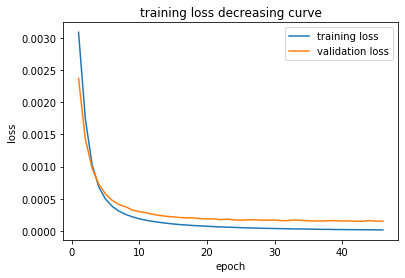

In [11]:
plt.plot(range(1,47), training_losses, label='training loss')
plt.plot(range(1,47), validation_losses, label='validation loss')
#plt.axvline(x=20, color='r', linestyle='--', label='best model')
#text(0.5, 0.5, 'matplotlib', horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)
plt.legend(loc='upper right')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('training loss decreasing curve')
plt.savefig('all_training_valid_loss')

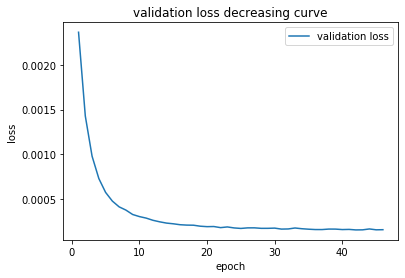

In [12]:
plt.plot(range(1,47), validation_losses, label='validation loss')
#plt.plot(range(1,26), training_losses, label='training loss')
#plt.axvline(x=20, color='r', linestyle='--', label='best model')
#text(0.5, 0.5, 'matplotlib', horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)
plt.legend(loc='upper right')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('validation loss decreasing curve')
plt.savefig('all_validation_loss')

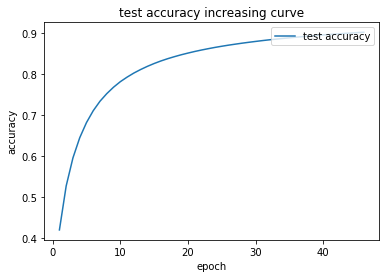

In [13]:
plt.plot(range(1,47), test_accuracy, label='test accuracy')
#plt.plot(range(1,26), training_losses, label='training loss')
#plt.axvline(x=20, color='r', linestyle='--', label='best model')
#text(0.5, 0.5, 'matplotlib', horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)
plt.legend(loc='upper right')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('test accuracy increasing curve')
plt.savefig('all_test_accuracy')

In [18]:
def plot_kernels(tensor, num_cols=6):
    if not tensor.ndim==4:
        raise Exception("assumes a 4D tensor")
    if not tensor.shape[-1]==3:
        raise Exception("last dim needs to be 3 to plot")
    num_kernels = tensor.shape[0]
    num_rows = 1+ num_kernels // num_cols
    fig = plt.figure(figsize=(num_cols,num_rows))
    for i in range(tensor.shape[0]):
        ax1 = fig.add_subplot(num_rows,num_cols,i+1)
        ax1.imshow(tensor[i])
        ax1.axis('off')
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])

    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.imshow()

In [19]:
def visTensor(tensor, ch=0, allkernels=False, nrow=8, padding=1): 
    n,c,w,h = tensor.shape

    if allkernels: tensor = tensor.view(n*c, -1, w, h)
    elif c != 3: tensor = tensor[:,ch,:,:].unsqueeze(dim=1)

    rows = np.min((tensor.shape[0] // nrow + 1, 64))    
    grid = utils.make_grid(tensor, nrow=nrow, normalize=True, padding=padding)
    plt.figure( figsize=(nrow,rows) )
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

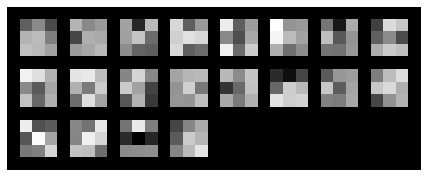

In [34]:
layer1 = model.main[3]
fil = layer1.weight.cpu().data.clone()
visTensor(fil, ch=0, allkernels=False)

plt.axis('off')
plt.ioff()
plt.show()
#plt.savefig('experiment_layer11.jpg')

In [26]:
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms, utils